# Tree

In [4]:
import numpy as np

class Node():
    def __init__(self, is_leaf, value, feature, threshold, left: None, right: None):
        self.is_leaf = is_leaf
        self.value = value
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

    def predict(self, X):
        if self.is_leaf:
            return self.value
        else:
            if X[self.feature] <= self.threshold:
                return self.left.predict(X)
            else:
                return self.right.predict(X)
            


class Tree():
    def __init__(self, max_depth, min_samples_leaf, min_gain_to_split):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_gain_to_split = min_gain_to_split

    def _build_node(self, X, r, S, depth, n_features):
        n_S = len(S)
        if n_S < 2 * self.min_samples_leaf or depth >= self.max_depth:
            nu = np.mean(r[S]) if n_S > 0 else 0
            return Node(is_leaf=True, value=nu, feature=None, threshold=None, left=None, right=None)
        
        best_gain = - np.inf
        best_feature = None
        best_threshold = None
        best_L = None
        best_R = None
        for j in range(n_features):
            pairs = [(X[i][j], r[i], i) for i in S]
            pairs.sort()
            sum_left = 0
            count_left = 0
            sum_right = np.sum(r[S])
            count_right = n_S

            for k in range(n_S - 1):
                (_, r_val, idx) = pairs[k]
                sum_left += r_val
                count_left += 1
                sum_right -= r_val
                count_right -= 1

                if count_left < self.min_samples_leaf or count_right < self.min_samples_leaf:
                    continue

                total_sum = sum_left + sum_right
                gain = (sum_left**2 / count_left) + (sum_right**2 / count_right) - (total_sum**2 / n_S)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = j
                    next_val = pairs[k+1][0]
                    best_threshold = (pairs[k][0] + next_val) / 2
                    
                    best_L = [i[2] for i in pairs[0:k+1]]
                    best_R = [i[2] for i in pairs[k+1:]]

        if best_gain < self.min_gain_to_split:
            nu = (1 / n_S) * sum(r)
            return Node(is_leaf=True, value=nu, feature=None, threshold=None, left=None, right=None)
        
        left_child = self._build_node(X, r, best_L, depth+1, n_features)
        right_child = self._build_node(X, r, best_R, depth+1, n_features)

        return Node(
            value=None,
            is_leaf=False,
            feature=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child
        )


    def fit(self, X, r):
        n = X.shape[0]
        d = X.shape[1]
        root_idx = np.arange(0, n)
        self.root = self._build_node(X=X, r=r, S=root_idx, depth=0, n_features=d)

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self.root.predict(X[i]))
        return predictions
        
    

завайбкодил сравнение с sklearn...

=== Тест 1: Одномерная зависимость ===
Наше дерево - MSE: 0.1136, R²: 0.7904
Sklearn дерево - MSE: 0.1657, R²: 0.6942


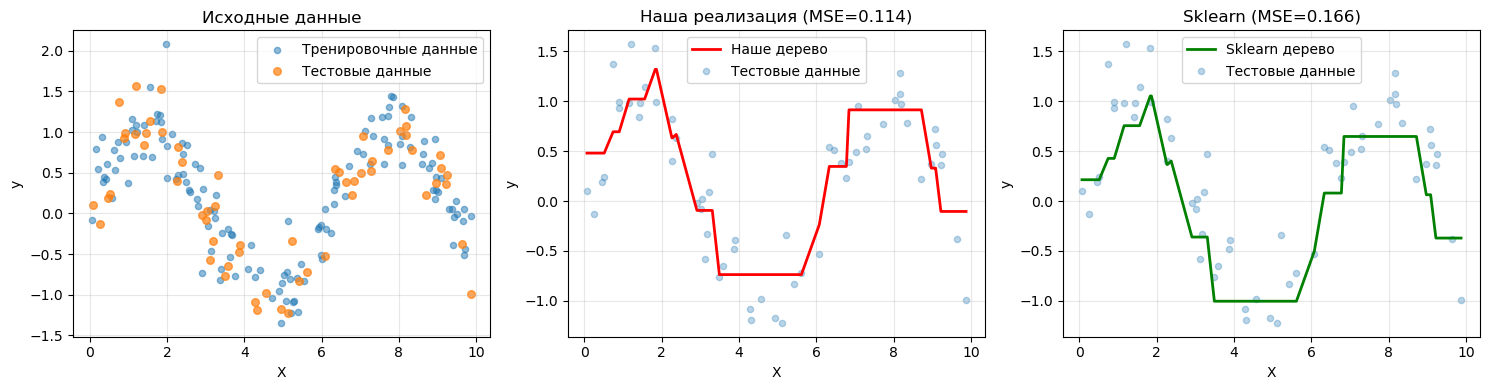


=== Тест 2: Двумерная зависимость ===


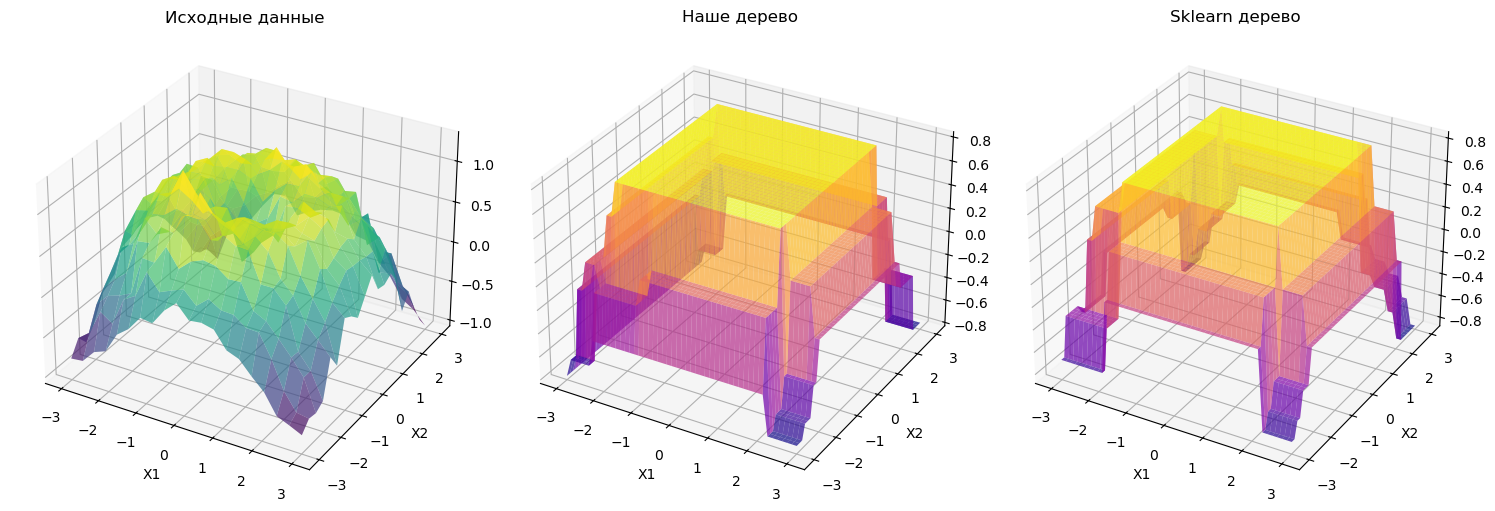


=== Тест 3: Сравнение при разных глубинах дерева ===
Глубина 1: Наше MSE=0.4215, Sklearn MSE=0.4212
Глубина 2: Наше MSE=0.2125, Sklearn MSE=0.2120
Глубина 3: Наше MSE=0.1388, Sklearn MSE=0.1379
Глубина 4: Наше MSE=0.1203, Sklearn MSE=0.1199
Глубина 5: Наше MSE=0.1105, Sklearn MSE=0.1099
Глубина 6: Наше MSE=0.1218, Sklearn MSE=0.1211
Глубина 7: Наше MSE=0.1168, Sklearn MSE=0.1163
Глубина 8: Наше MSE=0.1284, Sklearn MSE=0.1278


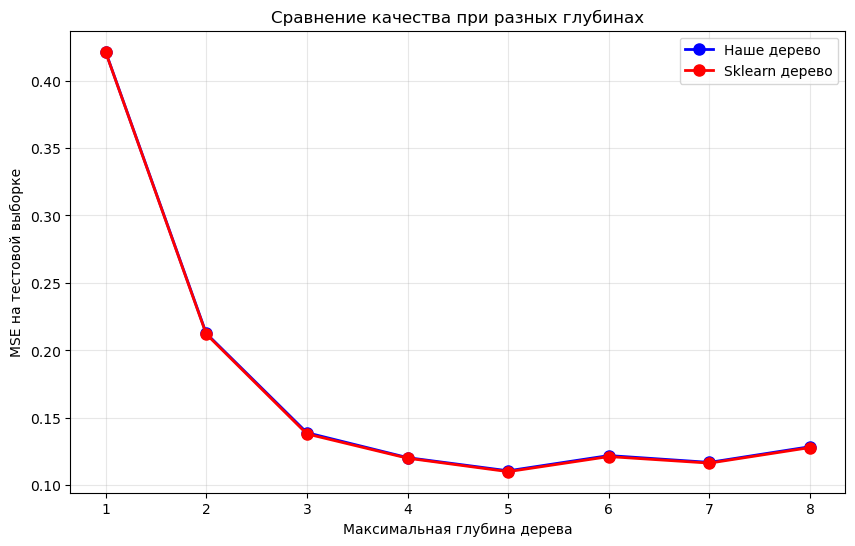


=== Тест 4: Сравнение времени выполнения ===
Размер 100: Наше время=0.0024s, Sklearn время=0.0013s
Размер 500: Наше время=0.0200s, Sklearn время=0.0022s
Размер 1000: Наше время=0.0394s, Sklearn время=0.0030s
Размер 2000: Наше время=0.0911s, Sklearn время=0.0039s
Размер 5000: Наше время=0.3765s, Sklearn время=0.0088s


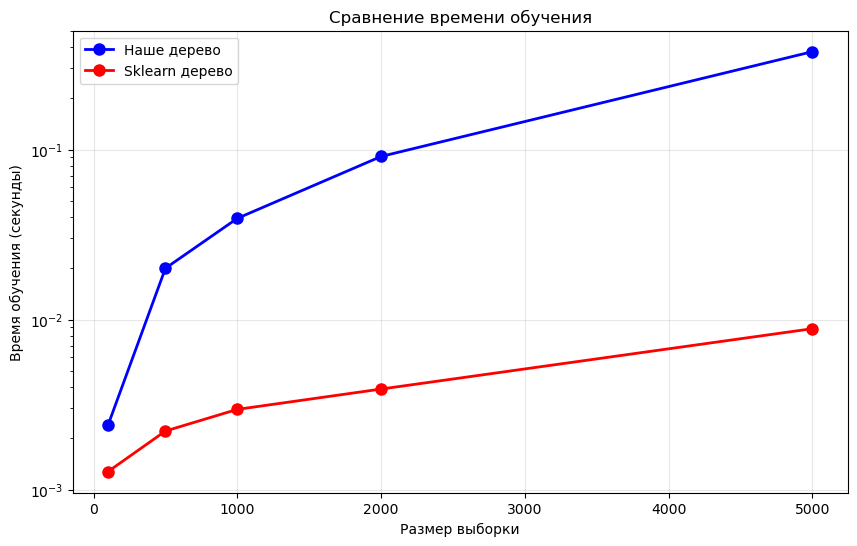


=== Тест 5: Сравнение структуры деревьев ===
Структура нашего дерева:
X[1] <= 2.50
  X[1] <= 1.50
    Лист: значение=-1.40
  X[1] > 1.50
    Лист: значение=-0.40
X[1] > 2.50
  X[0] <= 3.00
    Лист: значение=0.60
  X[0] > 3.00
    Лист: значение=1.60

Структура sklearn дерева:


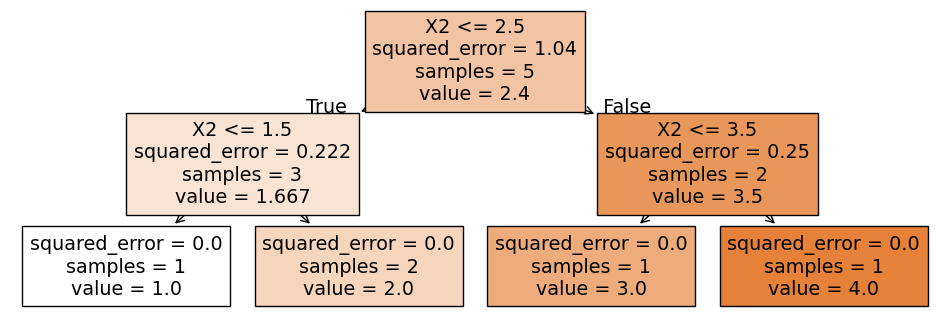

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Функция для сравнения
def compare_trees_visualization():
    """Визуальное сравнение нашего дерева и sklearn"""
    
    # Создаем синтетические данные
    np.random.seed(42)
    n_samples = 200
    
    # 1. Простая одномерная зависимость
    print("=== Тест 1: Одномерная зависимость ===")
    X1 = np.random.rand(n_samples, 1) * 10
    y1 = np.sin(X1.flatten()) + np.random.randn(n_samples) * 0.3
    r1 = y1 - np.mean(y1)
    
    # Разделяем на тренировочную и тестовую выборки
    X1_train, X1_test, y1_train, y1_test, r1_train, r1_test = train_test_split(
        X1, y1, r1, test_size=0.3, random_state=42
    )
    
    # Обучаем оба дерева
    our_tree1 = Tree(max_depth=4, min_samples_leaf=5, min_gain_to_split=0)
    our_tree1.fit(X1_train, r1_train)
    
    sklearn_tree1 = DecisionTreeRegressor(
        max_depth=4,
        min_samples_leaf=5,
        random_state=42
    )
    sklearn_tree1.fit(X1_train, r1_train)
    
    # Предсказания
    our_preds1 = our_tree1.predict(X1_test) + np.mean(y1_train)
    sklearn_preds1 = sklearn_tree1.predict(X1_test)
    
    # Метрики
    our_mse1 = mean_squared_error(y1_test, our_preds1)
    sklearn_mse1 = mean_squared_error(y1_test, sklearn_preds1)
    
    our_r2_1 = r2_score(y1_test, our_preds1)
    sklearn_r2_1 = r2_score(y1_test, sklearn_preds1)
    
    print(f"Наше дерево - MSE: {our_mse1:.4f}, R²: {our_r2_1:.4f}")
    print(f"Sklearn дерево - MSE: {sklearn_mse1:.4f}, R²: {sklearn_r2_1:.4f}")
    
    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Сортируем для красивого графика
    sort_idx = np.argsort(X1_test.flatten())
    X1_test_sorted = X1_test[sort_idx]
    y1_test_sorted = y1_test[sort_idx]
    
    axes[0].scatter(X1_train, y1_train, alpha=0.5, label='Тренировочные данные', s=20)
    axes[0].scatter(X1_test, y1_test, alpha=0.7, label='Тестовые данные', s=30)
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('y')
    axes[0].set_title('Исходные данные')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(X1_test_sorted, our_preds1[sort_idx], 'r-', linewidth=2, label='Наше дерево')
    axes[1].scatter(X1_test, y1_test, alpha=0.3, s=20, label='Тестовые данные')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('y')
    axes[1].set_title(f'Наша реализация (MSE={our_mse1:.3f})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(X1_test_sorted, sklearn_preds1[sort_idx], 'g-', linewidth=2, label='Sklearn дерево')
    axes[2].scatter(X1_test, y1_test, alpha=0.3, s=20, label='Тестовые данные')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('y')
    axes[2].set_title(f'Sklearn (MSE={sklearn_mse1:.3f})')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Двумерная зависимость
    print("\n=== Тест 2: Двумерная зависимость ===")
    
    # Создаем сетку
    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X2, Y2 = np.meshgrid(x, y)
    
    # Целевая функция
    Z = np.sin(np.sqrt(X2**2 + Y2**2)) + np.random.randn(*X2.shape) * 0.1
    
    # Подготовка данных
    X2_flat = np.column_stack([X2.flatten(), Y2.flatten()])
    Z_flat = Z.flatten()
    r2_flat = Z_flat - np.mean(Z_flat)
    
    # Обучаем деревья
    our_tree2 = Tree(max_depth=5, min_samples_leaf=3, min_gain_to_split=0)
    our_tree2.fit(X2_flat, r2_flat)
    
    sklearn_tree2 = DecisionTreeRegressor(
        max_depth=5,
        min_samples_leaf=3,
        random_state=42
    )
    sklearn_tree2.fit(X2_flat, Z_flat)  # sklearn работает с y, а не с r
    
    # Создаем сетку для предсказаний
    x_pred = np.linspace(-3, 3, 50)
    y_pred = np.linspace(-3, 3, 50)
    X_pred, Y_pred = np.meshgrid(x_pred, y_pred)
    X_pred_flat = np.column_stack([X_pred.flatten(), Y_pred.flatten()])
    
    # Предсказания
    our_preds2 = our_tree2.predict(X_pred_flat) + np.mean(Z_flat)
    sklearn_preds2 = sklearn_tree2.predict(X_pred_flat)
    
    our_preds2_grid = our_preds2.reshape(X_pred.shape)
    sklearn_preds2_grid = sklearn_preds2.reshape(X_pred.shape)
    
    # Визуализация 3D
    fig = plt.figure(figsize=(15, 5))
    
    # Исходные данные
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X2, Y2, Z, alpha=0.7, cmap='viridis')
    ax1.set_title('Исходные данные')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('y')
    
    # Наше дерево
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X_pred, Y_pred, our_preds2_grid, alpha=0.7, cmap='plasma')
    ax2.set_title('Наше дерево')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('y')
    
    # Sklearn дерево
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X_pred, Y_pred, sklearn_preds2_grid, alpha=0.7, cmap='plasma')
    ax3.set_title('Sklearn дерево')
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_zlabel('y')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Сравнение на разных глубинах
    print("\n=== Тест 3: Сравнение при разных глубинах дерева ===")
    
    depths = [1, 2, 3, 4, 5, 6, 7, 8]
    our_mse_list = []
    sklearn_mse_list = []
    
    for depth in depths:
        # Наше дерево
        our_tree = Tree(max_depth=depth, min_samples_leaf=2, min_gain_to_split=0)
        our_tree.fit(X1_train, r1_train)
        our_preds = our_tree.predict(X1_test) + np.mean(y1_train)
        our_mse = mean_squared_error(y1_test, our_preds)
        our_mse_list.append(our_mse)
        
        # Sklearn дерево
        sklearn_tree = DecisionTreeRegressor(
            max_depth=depth,
            min_samples_leaf=2,
            random_state=42
        )
        sklearn_tree.fit(X1_train, y1_train)
        sklearn_preds = sklearn_tree.predict(X1_test)
        sklearn_mse = mean_squared_error(y1_test, sklearn_preds)
        sklearn_mse_list.append(sklearn_mse)
        
        print(f"Глубина {depth}: Наше MSE={our_mse:.4f}, Sklearn MSE={sklearn_mse:.4f}")
    
    # График сравнения MSE
    plt.figure(figsize=(10, 6))
    plt.plot(depths, our_mse_list, 'bo-', linewidth=2, markersize=8, label='Наше дерево')
    plt.plot(depths, sklearn_mse_list, 'ro-', linewidth=2, markersize=8, label='Sklearn дерево')
    plt.xlabel('Максимальная глубина дерева')
    plt.ylabel('MSE на тестовой выборке')
    plt.title('Сравнение качества при разных глубинах')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 4. Сравнение времени выполнения
    print("\n=== Тест 4: Сравнение времени выполнения ===")
    
    import time
    
    sizes = [100, 500, 1000, 2000, 5000]
    our_times = []
    sklearn_times = []
    
    for size in sizes:
        X_temp = np.random.rand(size, 3)
        y_temp = X_temp[:, 0] * 2 + X_temp[:, 1] * 3 + np.random.randn(size) * 0.5
        r_temp = y_temp - np.mean(y_temp)
        
        # Наше дерево
        start = time.time()
        our_tree = Tree(max_depth=5, min_samples_leaf=5, min_gain_to_split=0)
        our_tree.fit(X_temp, r_temp)
        our_time = time.time() - start
        our_times.append(our_time)
        
        # Sklearn дерево
        start = time.time()
        sklearn_tree = DecisionTreeRegressor(
            max_depth=5,
            min_samples_leaf=5,
            random_state=42
        )
        sklearn_tree.fit(X_temp, y_temp)
        sklearn_time = time.time() - start
        sklearn_times.append(sklearn_time)
        
        print(f"Размер {size}: Наше время={our_time:.4f}s, Sklearn время={sklearn_time:.4f}s")
    
    # График времени выполнения
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, our_times, 'bo-', linewidth=2, markersize=8, label='Наше дерево')
    plt.plot(sizes, sklearn_times, 'ro-', linewidth=2, markersize=8, label='Sklearn дерево')
    plt.xlabel('Размер выборки')
    plt.ylabel('Время обучения (секунды)')
    plt.title('Сравнение времени обучения')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Логарифмическая шкала для наглядности
    plt.show()
    
    # 5. Сравнение структуры деревьев
    print("\n=== Тест 5: Сравнение структуры деревьев ===")
    
    # Обучаем деревья на маленькой выборке для наглядности
    X_small = np.array([[1, 2], [2, 3], [3, 1], [4, 4], [5, 2]])
    y_small = np.array([2, 3, 1, 4, 2])
    r_small = y_small - np.mean(y_small)
    
    our_tree_small = Tree(max_depth=2, min_samples_leaf=1, min_gain_to_split=0)
    our_tree_small.fit(X_small, r_small)
    
    sklearn_tree_small = DecisionTreeRegressor(
        max_depth=2,
        min_samples_leaf=1,
        random_state=42
    )
    sklearn_tree_small.fit(X_small, y_small)
    
    # Функция для печати структуры нашего дерева
    def print_our_tree(node, depth=0):
        indent = "  " * depth
        if node.is_leaf:
            print(f"{indent}Лист: значение={node.value:.2f}")
        else:
            print(f"{indent}X[{node.feature}] <= {node.threshold:.2f}")
            print_our_tree(node.left, depth + 1)
            print(f"{indent}X[{node.feature}] > {node.threshold:.2f}")
            print_our_tree(node.right, depth + 1)
    
    print("Структура нашего дерева:")
    if our_tree_small.root:
        print_our_tree(our_tree_small.root)
    
    print("\nСтруктура sklearn дерева:")
    from sklearn.tree import plot_tree
    plt.figure(figsize=(12, 4))
    plot_tree(sklearn_tree_small, filled=True, feature_names=['X1', 'X2'])
    plt.show()
    
    return {
        'our_mse': our_mse1,
        'sklearn_mse': sklearn_mse1,
        'our_r2': our_r2_1,
        'sklearn_r2': sklearn_r2_1,
        'depth_comparison': list(zip(depths, our_mse_list, sklearn_mse_list)),
        'time_comparison': list(zip(sizes, our_times, sklearn_times))
    }

# Запуск сравнения
if __name__ == "__main__":
    results = compare_trees_visualization()

# Gradient Boosting

In [5]:
from Losses import MSELoss
from GradientBoosting import MyGradientBoosting
import numpy as np

ModuleNotFoundError: No module named 'Trees.Trees'; 'Trees' is not a package

In [6]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

np.random.seed(42)
X = np.random.rand(100, 2)
y = 2*X[:, 0] + 3*X[:, 1] + np.random.randn(100)*0.1

sklearn_model = GradientBoostingRegressor(learning_rate=0.1,
        n_estimators=20,
        max_depth=3,
        min_samples_leaf=5,
        random_state=42)

sklearn_model.fit(X, y)
sklearn_pred = sklearn_model.predict(X)
sklearn_mse = mean_squared_error(y, sklearn_pred)

your_model = MyGradientBoosting(
        loss=MSELoss(),
        learning_rate=0.1,
        n_estimators=20,
        subsampling=1,
        max_depth=3,
        min_samples_leaf=5,
        min_gain_to_split=0.0
    )

your_model.fit(X, y)
your_pred = your_model.predict(X)
your_mse = mean_squared_error(y, your_pred)

print(f"Sklearn MSE: {sklearn_mse:.6f}")
print(f"My MSE: {your_mse:.6f}")

Sklearn MSE: 0.036017
My MSE: 0.036017


# XGBoost

In [6]:
import numpy as np

class Node:
    def __init__(self, is_leaf, value, feature, threshold, left: None, right: None):
        self.is_leaf = is_leaf
        self.value = value
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

    def predict(self, X):
        if self.is_leaf:
            return self.value
        else:
            if X[self.feature] <= self.threshold:
                return self.left.predict(X)
            else:
                return self.right.predict(X)
            


class Tree:
    def __init__(self, max_depth, min_samples_leaf, min_gain_to_split):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_gain_to_split = min_gain_to_split

    def _build_node(self, X, r, S, depth, n_features):
        n_S = len(S)
        if n_S < 2 * self.min_samples_leaf or depth >= self.max_depth:
            nu = np.mean(r[S]) if n_S > 0 else 0
            return Node(is_leaf=True, value=nu, feature=None, threshold=None, left=None, right=None)
        
        best_gain = - np.inf
        best_feature = None
        best_threshold = None
        best_L = None
        best_R = None
        for j in range(n_features):
            pairs = [(X[i][j], r[i], i) for i in S]
            pairs.sort()
            sum_left = 0
            count_left = 0
            sum_right = np.sum(r[S])
            count_right = n_S

            for k in range(n_S - 1):
                (_, r_val, idx) = pairs[k]
                sum_left += r_val
                count_left += 1
                sum_right -= r_val
                count_right -= 1

                if count_left < self.min_samples_leaf or count_right < self.min_samples_leaf:
                    continue

                total_sum = sum_left + sum_right
                gain = (sum_left**2 / count_left) + (sum_right**2 / count_right) - (total_sum**2 / n_S)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = j
                    next_val = pairs[k+1][0]
                    best_threshold = (pairs[k][0] + next_val) / 2
                    
                    best_L = [i[2] for i in pairs[0:k+1]]
                    best_R = [i[2] for i in pairs[k+1:]]

        if best_gain < self.min_gain_to_split:
            nu = (1 / n_S) * sum(r)
            return Node(is_leaf=True, value=nu, feature=None, threshold=None, left=None, right=None)
        
        left_child = self._build_node(X, r, best_L, depth+1, n_features)
        right_child = self._build_node(X, r, best_R, depth+1, n_features)

        return Node(
            value=None,
            is_leaf=False,
            feature=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child
        )

    def fit(self, X, r):
        n = X.shape[0]
        d = X.shape[1]
        root_idx = np.arange(0, n)
        self.root = self._build_node(X=X, r=r, S=root_idx, depth=0, n_features=d)

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self.root.predict(X[i]))
        return np.array(predictions, dtype=float)
        

class XGBoostTree:
    def __init__(self, reg_lambda, reg_alpha, gamma, max_depth, min_child_weight, min_gain_to_split):
        self.root = None
        self.reg_lambda = reg_lambda
        self.reg_alpha = reg_alpha
        self.gamma = gamma
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.min_gain_to_split = min_gain_to_split

    def _compute_weight(self, G, H):
        if G > self.reg_alpha:
            return - (G - self.reg_alpha) / (H + self.reg_lambda)
        elif G < -self.reg_alpha:
            return - (G + self.reg_alpha) / (H + self.reg_lambda)
        else:
            return 0

    def _build_node(self, X, g, h, S, depth, n_features):
        G = np.sum(g[S])
        H = np.sum(h[S])
        n_S = len(S)

        if depth >= self.max_depth:
            w = self._compute_weight(G, H)
            return Node(is_leaf=True, value=w, feature=None, 
                        threshold=None, left=None, right=None)

        best_gain = - np.inf
        best_feature = None
        best_threshold = None
        best_L = None
        best_R = None
        for j in range(n_features):
            pairs = [(X[i][j], g[i], h[i], i) for i in S]
            pairs.sort()

            G_L = 0
            H_L = 0
            G_R = G
            H_R = H

            for k in range(n_S - 1):
                (_, g_val, h_val, idx) = pairs[k]
                G_L += g_val
                H_L += h_val
                G_R -= g_val
                H_R -= h_val

                if H_L < self.min_child_weight or H_R < self.min_child_weight:
                    continue

                gain = 0.5 * (
                    G_L * G_L / (H_L + self.reg_lambda) +
                    G_R * G_R / (H_R + self.reg_lambda) -
                    G * G / (H + self.reg_lambda)
                ) - self.gamma

                if gain > best_gain:
                    best_gain = gain
                    best_feature = j
                    next_val = pairs[k+1][0]
                    best_threshold = (pairs[k][0] + next_val) / 2
                    
                    best_L = [i[3] for i in pairs[0:k+1]]
                    best_R = [i[3] for i in pairs[k+1:]]

        if best_gain < self.min_gain_to_split:
            w = self._compute_weight(G, H)
            return Node(is_leaf=True, value=w, feature=None, 
                        threshold=None, left=None, right=None)
        

        left_child = self._build_node(X, g, h, best_L, depth+1, n_features)
        right_child = self._build_node(X, g, h, best_R, depth+1, n_features)

        return Node(
            value=None,
            is_leaf=False,
            feature=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child
        )

    def fit(self, X, g, h):
        n = X.shape[0]
        d = X.shape[1]
        root_idx = np.arange(0, n)
        self.root = self._build_node(X, g, h, root_idx, depth=0, n_features=d)

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self.root.predict(X[i]))
        return np.array(predictions, dtype=float)


In [8]:
import numpy as np

class Loss:        
    def base_predictions(self, y):
        pass

    def gradients(self, F_i, y_i) -> float:
        pass

    def hessians(self, F_i, y_i) -> float:
        pass

class MSELoss(Loss):
    def base_predictions(self, y):
        return np.mean(y)

    def gradients(self, F_i, y_i) -> float:
        return F_i - y_i
    
    def hessians(self, F_i, y_i):
        return np.ones_like(F_i)
    
class MAELoss(Loss):
    def base_predictions(self, y):
        return np.mean(y)

    def gradients(self, F_i, y_i):
        return F_i - y_i
    
    def hessians(self, F_i, y_i):
        return np.ones_like(F_i)
    
class LogisticLoss(Loss):
    def _sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1.0 / (1.0 + np.exp(-x))
    
    def base_predictions(self, y):
        pos_ratio = np.mean(y)
        pos_ratio = np.clip(pos_ratio, 1e-15, 1 - 1e-15)
        return np.log(pos_ratio / (1 - pos_ratio))
    
    def gradients(self, F_i, y_i):
        p = self._sigmoid(F_i)
        return p - y_i
    
    def hessians(self, F_i, y_i):
        p = self._sigmoid(F_i)
        return p * (1 - p)


In [11]:
class MyXGBoost:
    def __init__(self, loss: Loss, learning_rate, n_estimators, subsampling, **tree_params):
        self.loss = loss
        self.learning_rate = learning_rate
        self.base_prediction = None
        self.trees = []
        self.n_estimators = n_estimators
        self.subsampling = subsampling
        self.tree_params = tree_params

    def _random_subset(self, n):
        size = int(self.subsampling * n)
        sample = np.random.choice(n, size, replace=False)
        return sample

    def fit(self, X, y):
        n = X.shape[0]
        self.base_prediction = self.loss.base_predictions(y)
        F = np.full(shape=n, fill_value=self.base_prediction)

        for t in range(self.n_estimators):
            subset_idx = self._random_subset(n)
            g = np.zeros(n, dtype=float)
            h = np.zeros(n, dtype=float)
            for i in subset_idx:
                g[i] = self.loss.gradients(F[i], y[i])
                h[i] = self.loss.hessians(F[i], y[i])

            tree = XGBoostTree(
                gamma = self.tree_params["gamma"],
                reg_lambda = self.tree_params["reg_lambda"],
                reg_alpha = self.tree_params["reg_alpha"],
                max_depth = self.tree_params["max_depth"],
                min_child_weight = self.tree_params["min_child_weight"],
                min_gain_to_split = self.tree_params["min_gain_to_split"]
            )
            tree.fit(X[subset_idx], g[subset_idx], h[subset_idx])

            tree_preds = tree.predict(X)
            F = F + self.learning_rate * tree_preds

            self.trees.append(tree)

    def predict(self, X):
        n = X.shape[0]
        predictions = np.full(shape=n, fill_value=self.base_prediction)
        for tree in self.trees:
            tree_predict = tree.predict(X)
            predictions = predictions + self.learning_rate * tree_predict
        
        return predictions

РЕГРЕССИЯ (MSE)
Самописный XGBoost - MSE: 1.4903
Sklearn GBM - MSE: 1.7183
Разница: 0.2280


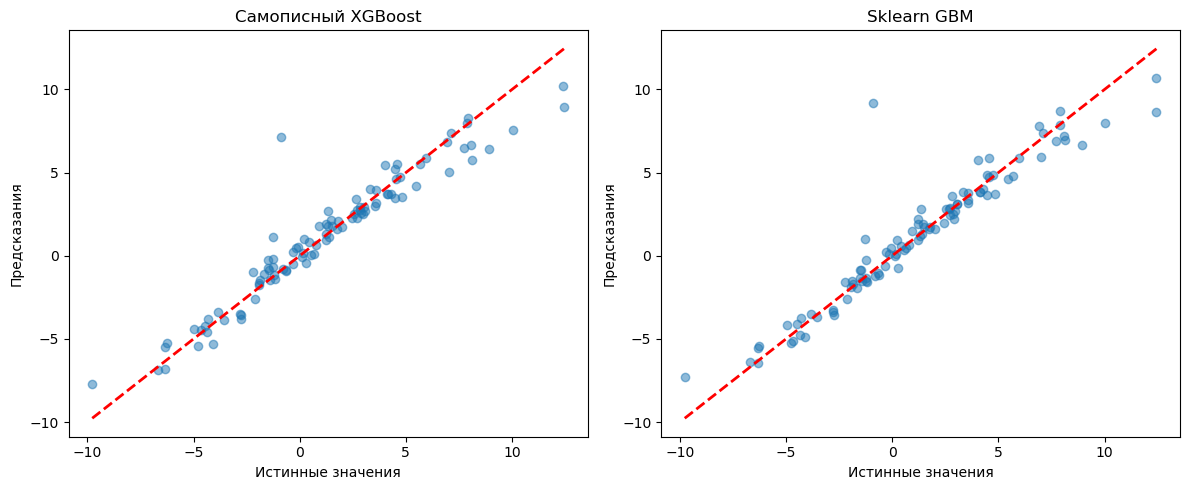


КЛАССИФИКАЦИЯ (Logistic Loss)
Самописный XGBoost - Accuracy: 0.9500
Sklearn GBM - Accuracy: 0.9500
Разница в accuracy: 0.0000

ТЕСТ НА ПЕРЕОБУЧЕНИЕ (маленькая выборка)
Самописный XGBoost - MSE на тренировочных данных: 0.0000
Sklearn GBM - MSE на тренировочных данных: 0.0000

ПРОСТОЙ ТЕСТ С 1 ФИЧЕЙ


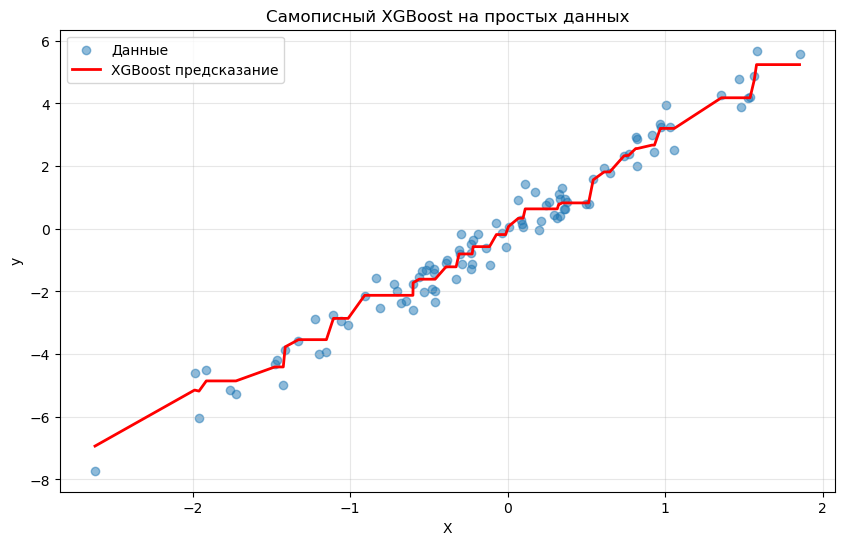

Количество деревьев в модели: 50
Базовое предсказание: -0.3004


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# Создаем простой синтетический датасет
def create_regression_data():
    np.random.seed(42)
    X = np.random.randn(500, 5)
    y = 2 * X[:, 0] + 1.5 * X[:, 1]**2 - 3 * X[:, 2] + 0.5 * np.random.randn(500)
    return X, y

def create_classification_data():
    np.random.seed(42)
    X = np.random.randn(500, 5)
    y = (X[:, 0] + X[:, 1] > 0).astype(int)
    return X, y

# Тестирование регрессии
print("=" * 60)
print("РЕГРЕССИЯ (MSE)")
print("=" * 60)

X, y = create_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ваш самописный XGBoost
mse_loss = MSELoss()
my_xgb = MyXGBoost(
    loss=mse_loss,
    learning_rate=0.1,
    n_estimators=100,
    subsampling=0.8,
    gamma=0,
    reg_lambda=1,
    reg_alpha=0,
    max_depth=3,
    min_child_weight=1,
    min_gain_to_split=0
)

my_xgb.fit(X_train, y_train)
my_predictions = my_xgb.predict(X_test)
my_mse = mean_squared_error(y_test, my_predictions)

print(f"Самописный XGBoost - MSE: {my_mse:.4f}")

# Sklearn Gradient Boosting
sklearn_gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
sklearn_gb.fit(X_train, y_train)
sklearn_predictions = sklearn_gb.predict(X_test)
sklearn_mse = mean_squared_error(y_test, sklearn_predictions)

print(f"Sklearn GBM - MSE: {sklearn_mse:.4f}")
print(f"Разница: {abs(my_mse - sklearn_mse):.4f}")

# Визуализация предсказаний
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, my_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания')
plt.title('Самописный XGBoost')

plt.subplot(1, 2, 2)
plt.scatter(y_test, sklearn_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания')
plt.title('Sklearn GBM')

plt.tight_layout()
plt.show()

# Тестирование классификации
print("\n" + "=" * 60)
print("КЛАССИФИКАЦИЯ (Logistic Loss)")
print("=" * 60)

X, y = create_classification_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ваш самописный XGBoost для классификации
logistic_loss = LogisticLoss()
my_xgb_class = MyXGBoost(
    loss=logistic_loss,
    learning_rate=0.1,
    n_estimators=100,
    subsampling=0.8,
    gamma=0,
    reg_lambda=1,
    reg_alpha=0,
    max_depth=3,
    min_child_weight=1,
    min_gain_to_split=0
)

my_xgb_class.fit(X_train, y_train)
my_probs = my_xgb_class.predict(X_test)
my_preds = (my_probs > 0.5).astype(int)
my_acc = accuracy_score(y_test, my_preds)

print(f"Самописный XGBoost - Accuracy: {my_acc:.4f}")

# Sklearn Gradient Boosting для классификации
sklearn_gb_class = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
sklearn_gb_class.fit(X_train, y_train)
sklearn_preds = sklearn_gb_class.predict(X_test)
sklearn_acc = accuracy_score(y_test, sklearn_preds)

print(f"Sklearn GBM - Accuracy: {sklearn_acc:.4f}")
print(f"Разница в accuracy: {abs(my_acc - sklearn_acc):.4f}")

# Тест на переобучение
print("\n" + "=" * 60)
print("ТЕСТ НА ПЕРЕОБУЧЕНИЕ (маленькая выборка)")
print("=" * 60)

np.random.seed(42)
X_small = np.random.randn(50, 3)
y_small = 2 * X_small[:, 0] + np.random.randn(50) * 0.1

# Самописный
mse_loss_small = MSELoss()
my_xgb_small = MyXGBoost(
    loss=mse_loss_small,
    learning_rate=0.1,
    n_estimators=200,  # Много деревьев для демонстрации
    subsampling=1.0,
    gamma=0,
    reg_lambda=1,
    reg_alpha=0,
    max_depth=6,  # Большая глубина
    min_child_weight=1,
    min_gain_to_split=0
)

my_xgb_small.fit(X_small, y_small)
train_preds_my = my_xgb_small.predict(X_small)
train_mse_my = mean_squared_error(y_small, train_preds_my)

print(f"Самописный XGBoost - MSE на тренировочных данных: {train_mse_my:.4f}")

# Sklearn
sklearn_gb_small = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
sklearn_gb_small.fit(X_small, y_small)
train_preds_sklearn = sklearn_gb_small.predict(X_small)
train_mse_sklearn = mean_squared_error(y_small, train_preds_sklearn)

print(f"Sklearn GBM - MSE на тренировочных данных: {train_mse_sklearn:.4f}")

# Простой тест с одной фичей
print("\n" + "=" * 60)
print("ПРОСТОЙ ТЕСТ С 1 ФИЧЕЙ")
print("=" * 60)

np.random.seed(42)
X_simple = np.random.randn(100, 1)
y_simple = 3 * X_simple[:, 0] + np.random.randn(100) * 0.5

simple_loss = MSELoss()
simple_xgb = MyXGBoost(
    loss=simple_loss,
    learning_rate=0.1,
    n_estimators=50,
    subsampling=1.0,
    gamma=0,
    reg_lambda=1,
    reg_alpha=0,
    max_depth=2,
    min_child_weight=1,
    min_gain_to_split=0
)

simple_xgb.fit(X_simple, y_simple)
simple_preds = simple_xgb.predict(X_simple)

# Визуализация для простого случая
plt.figure(figsize=(10, 6))
plt.scatter(X_simple, y_simple, alpha=0.5, label='Данные')
sorted_idx = np.argsort(X_simple[:, 0])
plt.plot(X_simple[sorted_idx], simple_preds[sorted_idx], 'r-', lw=2, label='XGBoost предсказание')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Самописный XGBoost на простых данных')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Количество деревьев в модели: {len(simple_xgb.trees)}")
print(f"Базовое предсказание: {simple_xgb.base_prediction:.4f}")